# Zbulimi i Mashtrimeve me Kartë Krediti: Një Qasje sipas CRISP-DM
## Kuptimi i Biznesit
Zbulimi i mashtrimeve me kartë krediti përbën një shembull tipik të një problemi me pabarazi klasash, ku numri i transaksioneve mashtruese është ndjeshëm më i vogël se ai i transaksioneve të rregullta për çdo bankë. Shumica e metodave për ndërtimin e modeleve punojnë mbi këto të dhëna të pabalancuara, çka shpesh çon në mbipërshtatje të modelit (overfitting) mbi të dhënat e testimit dhe në njëanshmëri drejt klasës dominuese, pra atë transaksioneve legjitime. Për këtë arsye, problemi mund të trajtohet si një problem i detektimit të anomalive.

Pyetje kyçe për analizë:

- Në çfarë orari ndodhin zakonisht mashtrimet me kartë krediti?
- Cilat janë prirjet e përgjithshme të shumave në transaksionet mashtruese?
- Si mund të balancohet grupi i të dhënave në mënyrë që modeli të mos mësojë vetëm nga transaksionet e rregullta?

In [1]:
# Importojmë libraritë e nevojshme
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

from mlxtend.plotting import plot_learning_curves
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, matthews_corrcoef

import warnings
warnings.filterwarnings("ignore")

## Detaje mbi Dataset-in
Dataseti përmban rreth 550,000 transaksione të kryera nga përdorues evropianë gjatë vitit 2023, dhe është anonimizuar për të ruajtur privatësinë Kaggle. Datasetin mund ta gjeni në linkun : [dataseti](https://www.kaggle.com/datasets/nelgiriyewithana/credit-card-fraud-detection-dataset-2023?select=creditcard_2023.csv)

Fushat kryesore përfshijnë:
id: Identifikues unik i transaksionit
V1–V28: Veçori anonimize të transformuara (për shembull, PCA) që përmbajnë informacione të lidhura me orën, vendndodhjen, formatin e transaksionit, etj. 
Amount: Shuma e transaksionit
Class: Etiketa binare (0 = e ligjshme, 1 = mashtruese) 

Shpërndarja e klasave është jashtëzakonisht e pabarabartë: transaksionet mashtruese përbëjnë rreth 0.17% të totalit.

In [2]:
# Lexojmë datasetin si një DataFrame
df = pd.read_csv('creditcard.csv')

In [3]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


## Përgatitja e të Dhënave
- Të dhënat nuk përmbajnë vlera të munguara, prandaj nuk është e nevojshme ndonjë ndërhyrje për menaxhimin e tyre.
- Variabla target është vetëm Class, e cila është një variabël binare (0 = e rregullt, 1 = mashtruese).
- Të gjitha veçoritë e tjera janë numerike, dhe kërkojnë vetëm standardizim (normalizim) për të bërë krahasimet më të sakta pas balancimit të dataset-it.
- Mesatarja e shumave në transaksione është 88.34, ndërsa devijimi standard i tyre është 250.12, duke treguar një shpërndarje të gjerë të vlerave.
- Koha (Time) është e shpërndarë në mënyrë të barabartë përgjatë gjithë të dhënave, dhe prandaj mund të trajtohet si një veçori e pavarur.
- Në këtë rast, nuk rekomandohet të hiqet apo të përjashtohet ndonjë veçori apo rresht, por fillimisht është më mirë të zhvillohet modeli duke i konsideruar të gjitha veçoritë si të pavarura.

In [4]:
# Përshkrimi i të dhënave
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
# Kolonat e dataset-it
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [6]:
# Kontrollojmë për vlera të munguara
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [7]:
def countplot_data(data, feature, hue=None):
    '''
    Metodë për të vizualizuar shpërndarjen (countplot) e një variabli në dataframe
    Parametrat:
        data (pd.DataFrame): Dataframe input
        feature (str): Emri i kolonës për të vizualizuar
        hue (str, opsionale): Emri i kolonës për ngjyrosje (p.sh. target)
    '''
    plt.figure(figsize=(10,6))
    sns.countplot(x=feature, data=data, hue=hue)
    plt.title(f'Shperndarja e "{feature}"')
    plt.xlabel(feature)
    plt.ylabel('Numri i rasteve')
    plt.show()

def pairplot_data_grid(data, feature1, feature2, target):
    '''
    Metodë për të ndërtuar një grafikun scatter (pairplot) midis dy variablave me ngjyrosje sipas target-it
    Parametrat:
        data (pd.DataFrame): Dataframe input
        feature1 (str): Emri i kolonës së parë
        feature2 (str): Emri i kolonës së dytë
        target (str): Emri i kolonës target (për ngjyrosje)
    '''
    g = sns.FacetGrid(data, hue=target, height=6)
    g.map(plt.scatter, feature1, feature2)
    g.add_legend()
    plt.title(f'Scatter plot i "{feature1}" dhe "{feature2}" me ngjyrosje sipas "{target}"')
    plt.show()


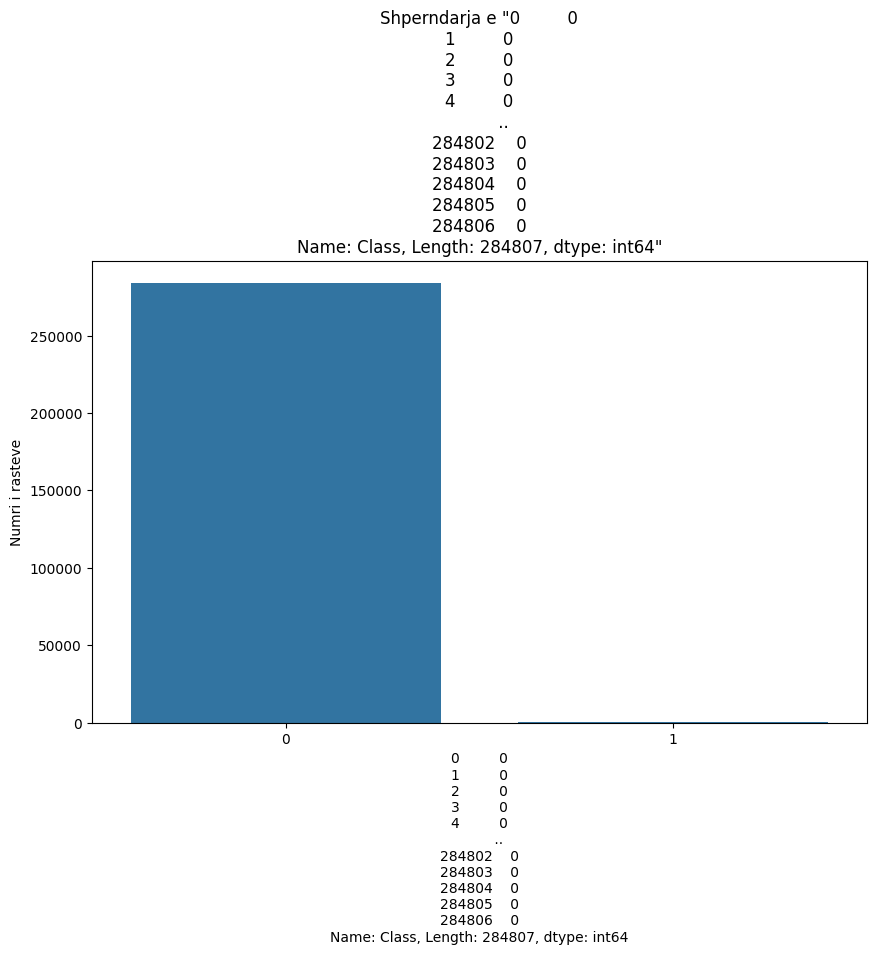

In [8]:
countplot_data(df, df.Class)

## Cili është relacioni midis transaksioneve mashtruese dhe shumës së parave?
Le të përpiqemi të kuptojmë natyrën e transaksioneve mashtruese dhe të nxjerrim një grup të përshtatshëm të tyre bazuar në shumën e transaksionit.

- Bazuar në grafikun tonë shpërndarës (scatter plot), ne hipotezojmë që të gjitha transaksionet mashtruese ndodhin për shuma më të vogla se 2500.

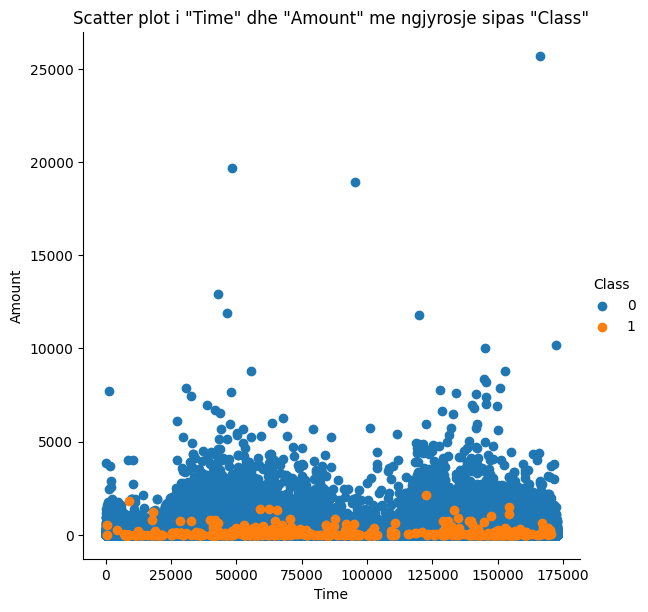

In [9]:
pairplot_data_grid(df, "Time", "Amount", "Class")

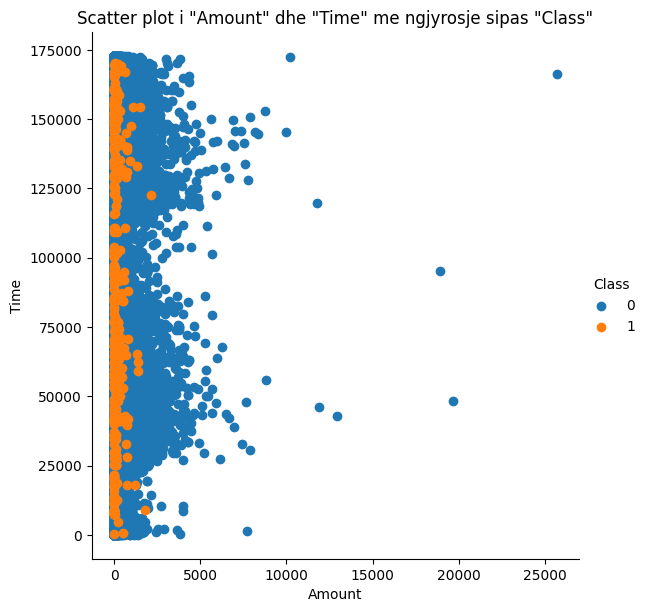

In [10]:
pairplot_data_grid(df, "Amount", "Time", "Class")

## Vëzhgime:
- Vërehet se transaksionet mashtruese zakonisht nuk kalojnë shumën prej 2500.
- Gjithashtu, transaksionet mashtruese janë të shpërndara në mënyrë të barabartë në kohë.
- Tani do të përpiqemi ta provojmë këtë me analiza dhe vizualizime të mëtejshme.

In [11]:
df_refine = df[["Time", "Amount", "Class"]]
amount_less = df_refine[df_refine["Amount"] < 2500].shape[0]
amount_more = df_refine[df_refine["Amount"] >= 2500].shape[0]

print("Numri i transaksioneve me shumë < 2500:", amount_less)
print("Numri i transaksioneve me shumë ≥ 2500:", amount_more)

Numri i transaksioneve me shumë < 2500: 284358
Numri i transaksioneve me shumë ≥ 2500: 449


In [12]:
percentage_less = (amount_less / df.shape[0]) * 100
print(f" Përqindja e transaksioneve me shumë më pak se 2500 është: {percentage_less:.4f}%")

 Përqindja e transaksioneve me shumë më pak se 2500 është: 99.8423%


Vërejmë që 99.85% e transaksioneve kanë shumë më pak se 2500.
Tani do të shohim sa nga këto janë mashtruese dhe sa janë legjitime.

In [13]:
# Filtro transaksionet me Amount < 2500
filtered_df = df_refine[df_refine["Amount"] < 2500]

# Numëro sa nga këto janë mashtruese (Class=1)
fraud = filtered_df[filtered_df["Class"] == 1].shape[0]

# Numëro sa janë legjitime (Class=0)
legitimate = filtered_df[filtered_df["Class"] == 0].shape[0]

print("Numri i mashtrimeve me Amount < 2500:", fraud)
print("Numri i transaksioneve legjitime me Amount < 2500:", legitimate)

Numri i mashtrimeve me Amount < 2500: 492
Numri i transaksioneve legjitime me Amount < 2500: 283866


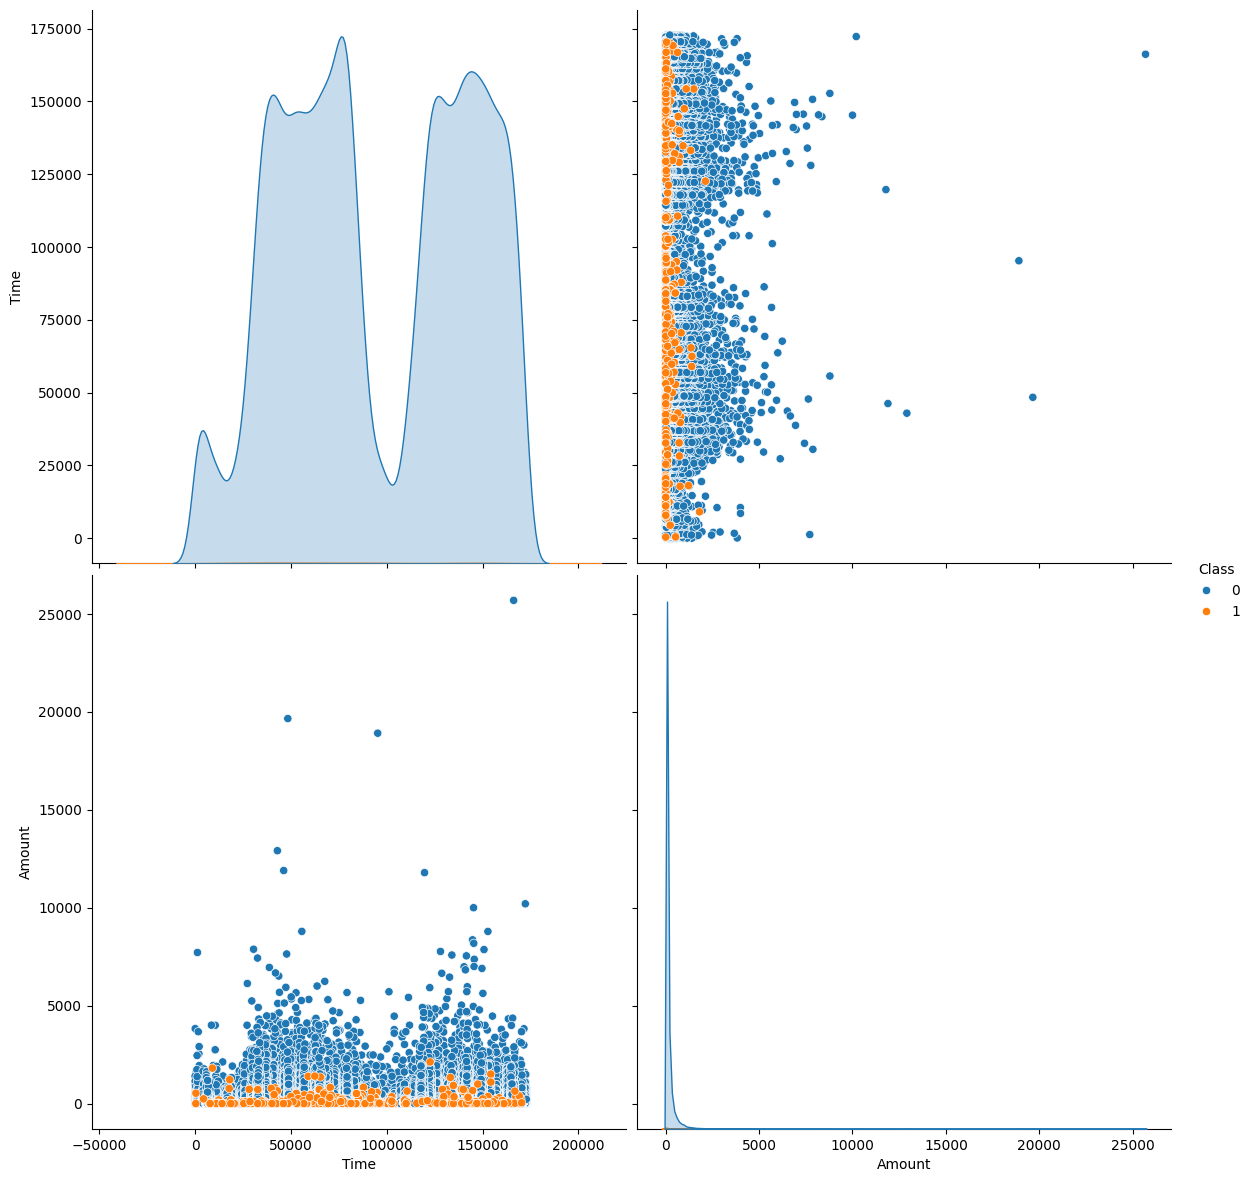

In [14]:
df_refine = df_refine.sort_values(by='Class', ascending=True) 
sns.pairplot(df_refine, hue="Class", height=6)
plt.show()

In [15]:
df.Class.value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

Pra, mund të themi që numri i transaksioneve mashtruese me shumë më pak se 2500 është i njëjtë me numrin total të transaksioneve mashtruese në dataset. Kjo do të thotë se të gjitha transaksionet mashtruese kanë shumë më pak se 2500.

## Cili është relacioni midis kohës dhe transaksioneve?

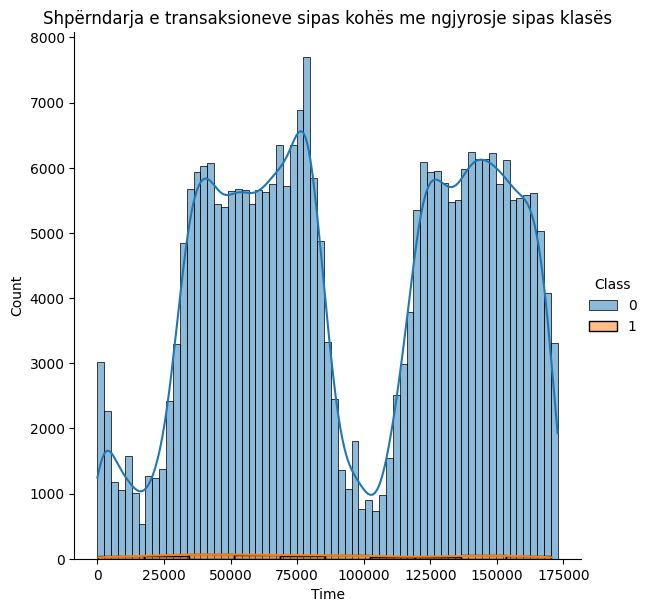

In [16]:
sns.FacetGrid(df_refine, hue="Class", height=6).map(sns.histplot, "Time", kde=True).add_legend()
plt.title("Shpërndarja e transaksioneve sipas kohës me ngjyrosje sipas klasës")
plt.show()

Nga grafiku i shpërndarjes që pamë më sipër, është e qartë se transaksionet mashtruese janë të shpërndara në mënyrë të njëtrajtshme gjatë gjithë periudhës kohore.


### Modelimi
- Studiojmë korrelacionet ndërmjet veçorive në dataset.
- Vizualizojmë korrelacionet me një heatmap.
- Ekzekutojmë Grid Search për të gjetur parametrat më të mirë për modelet.
- Bëjmë përmirësime (fine tuning) të klasifikuesve në bazë të rezultateve.
- Krijojmë pipeline për evaluimin e modeleve në mënyrë të automatizuar dhe të qëndrueshme.

<Axes: >

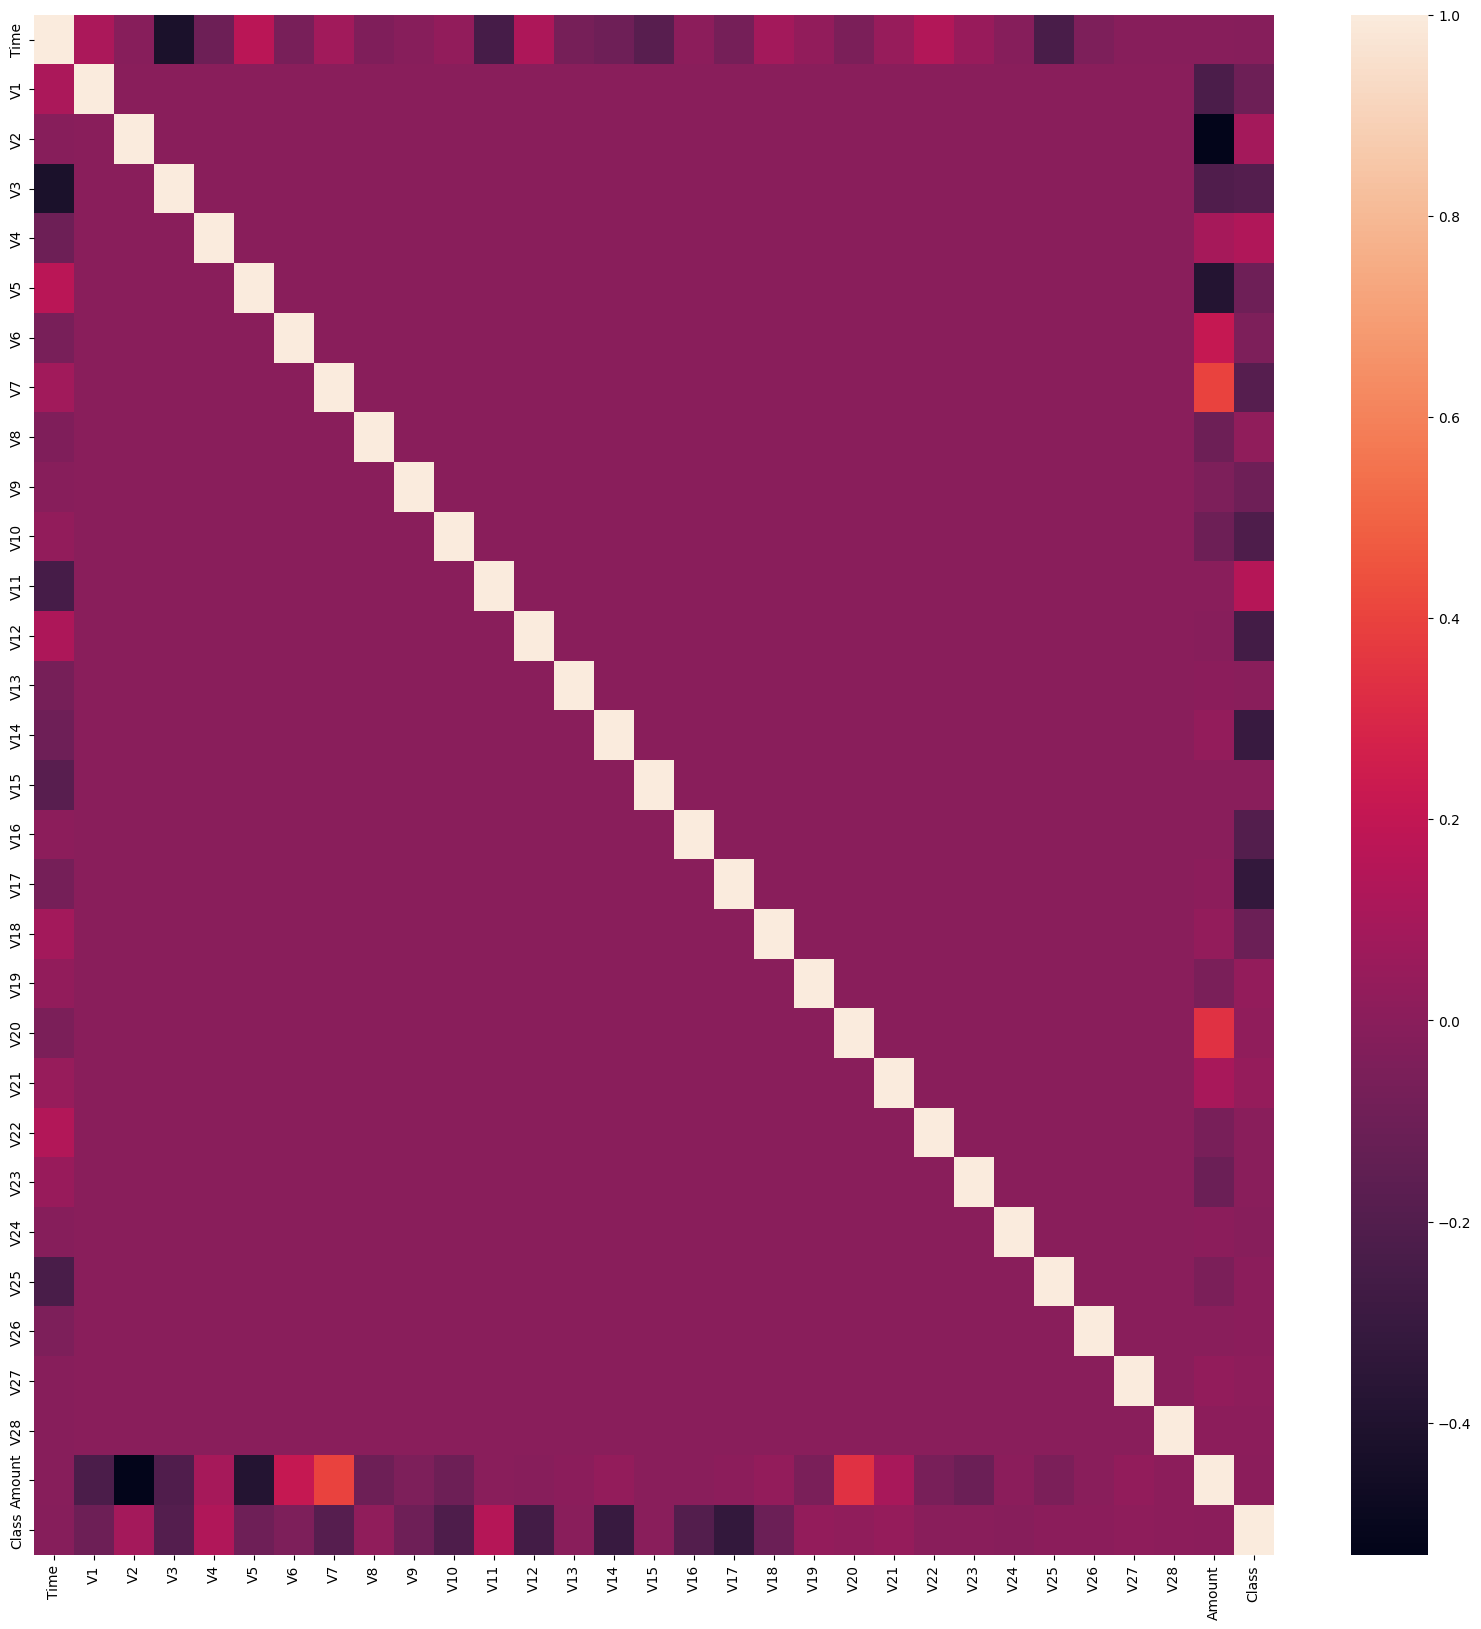

In [17]:
plt.figure(figsize=(20,20))
df_corr = df.corr()
sns.heatmap(df_corr)

In [18]:
# Përcakto veçoritë dhe target-in
X = df.drop(labels='Class', axis=1)  # Të gjitha kolonat përveç 'Class'
y = df['Class']                      # Kolona target

# Ndarja në train dhe test (70% train, 30% test), me stratify sipas klasës
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)


### Si do të balancosh transaksionet mashtruese dhe legjitime në të dhëna?

In [19]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [20]:
mutual_infos = pd.Series(
    data=mutual_info_classif(X_res, y_res, discrete_features=False, random_state=1),
    index=X_train.columns
)

In [21]:
mutual_infos.sort_values(ascending=False)

V14       0.535044
V10       0.464775
V12       0.456052
V17       0.438193
V4        0.427427
V11       0.404040
Amount    0.392909
V3        0.387187
V16       0.335317
V7        0.304171
V2        0.291484
V9        0.256678
Time      0.247989
V21       0.235010
V27       0.229914
V1        0.220736
V18       0.198262
V8        0.174371
V6        0.171973
V28       0.170495
V5        0.157362
V20       0.107488
V19       0.099836
V23       0.067332
V24       0.063567
V26       0.046974
V25       0.031606
V22       0.031539
V13       0.024931
V15       0.022442
dtype: float64

Pra, mund të themi që veçoritë më të korreluara me target-in, pasi kemi zgjidhur pabarazinë e klasave me metodën Synthetic Minority Oversampling (SMOTE), janë V14, V10, V12, V17 dhe V4.

### Vlerësimi
Për të vlerësuar performancën e klasifikuesve përdorim metrika të ndryshme si:
- AUC-ROC Score (Syprina nën kurbën ROC)
- Raporti i Klasifikimit (Classification Report)
- Saktësia (Accuracy)
- F1-Score

In [22]:
def grid_eval(grid_clf):
    """
    Metodë për të shfaqur rezultatin më të mirë dhe parametrat optimalë nga Grid Search
    Parameter:
        grid_clf: Modeli i trajnuar me Grid Search
    """
    print("Best Score:", grid_clf.best_score_)
    print("Best Parameters:", grid_clf.best_params_)

def evaluation(y_test, grid_clf, X_test):
    """
    Metodë për të përllogaritur dhe shfaqur:
        1. Raportin e Klasifikimit
        2. F1-score
        3. AUC-ROC score
        4. Saktësinë (Accuracy)
    Parametrat:
        y_test: Targeti i të dhënave test
        grid_clf: Modeli i trajnuar (Grid Search)
        X_test: Të dhënat e veçorive për testim
    """
    y_pred = grid_clf.predict(X_test)

    print('CLASSIFICATION REPORT:')
    print(classification_report(y_test, y_pred))

    print('AUC-ROC:', roc_auc_score(y_test, y_pred))
    print('F1-Score:', f1_score(y_test, y_pred))
    print('Accuracy:', accuracy_score(y_test, y_pred))


In [23]:
param_grid_sgd = [{
    'model__loss': ['log'],
    'model__penalty': ['l1', 'l2'],
    'model__alpha': np.logspace(-3, 3, 20)
}, {
    'model__loss': ['hinge'],
    'model__alpha': np.logspace(-3, 3, 20),
    'model__class_weight': [None, 'balanced']
}]

pipeline_sgd = Pipeline([
    ('scaler', StandardScaler(copy=False)),
    ('model', SGDClassifier(max_iter=1000, tol=1e-3, random_state=1, warm_start=True))
])

MCC_scorer = make_scorer(matthews_corrcoef)

grid_sgd = GridSearchCV(
    estimator=pipeline_sgd,
    param_grid=param_grid_sgd,
    scoring=MCC_scorer,
    n_jobs=-1,
    pre_dispatch='2*n_jobs',
    cv=5,
    verbose=1,
    return_train_score=False
)

grid_sgd.fit(X_res, y_res)


Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler(copy=False)),
                                       ('model',
                                        SGDClassifier(random_state=1,
                                                      warm_start=True))]),
             n_jobs=-1,
             param_grid=[{'model__alpha': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00,...
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03]),
                          'model__class_weight': [None, 'balanced'],
                          'model__loss': ['hinge']}],
             scoring=make_scorer(matthews_corrcoef, response_method='predict'),
             verbose=1)

In [24]:
grid_eval(grid_sgd)

Best Score: 0.9499773085502039
Best Parameters: {'model__alpha': np.float64(0.001), 'model__class_weight': None, 'model__loss': 'hinge'}


In [25]:
evaluation(y_test, grid_sgd, X_test)

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85295
           1       0.17      0.89      0.28       148

    accuracy                           0.99     85443
   macro avg       0.58      0.94      0.64     85443
weighted avg       1.00      0.99      0.99     85443

AUC-ROC: 0.942112192502016
F1-Score: 0.2826552462526767
Accuracy: 0.9921585150334141


In [26]:
pipeline_rf = Pipeline([
    ('model', RandomForestClassifier(n_jobs=-1, random_state=1))
])
param_grid_rf = {'model__n_estimators': [75]}
grid_rf = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid_rf, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)
grid_rf.fit(X_res, y_res)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=1))]),
             n_jobs=-1, param_grid={'model__n_estimators': [75]},
             scoring=make_scorer(matthews_corrcoef, response_method='predict'),
             verbose=1)

In [27]:
grid_eval(grid_rf)

Best Score: 0.9997488027874292
Best Parameters: {'model__n_estimators': 75}


In [28]:
evaluation(y_test, grid_rf, X_test)

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       1.00      0.23      0.37       148

    accuracy                           1.00     85443
   macro avg       1.00      0.61      0.69     85443
weighted avg       1.00      1.00      1.00     85443

AUC-ROC: 0.6148648648648649
F1-Score: 0.37362637362637363
Accuracy: 0.9986657771847899


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Pipeline me standardizim dhe Logistic Regression
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=1, max_iter=1000))
])

# Parametrat që do testohen në GridSearchCV
param_grid_lr = {
    'model__penalty': ['l2'],
    'model__class_weight': [None, 'balanced']
}

# Grid Search me MCC si metrikë vlerësimi
grid_lr = GridSearchCV(
    estimator=pipeline_lr,
    param_grid=param_grid_lr,
    scoring=MCC_scorer,
    n_jobs=-1,
    pre_dispatch='2*n_jobs',
    cv=5,
    verbose=1,
    return_train_score=False
)

# Trajnimi me të dhënat e balancuara (X_res, y_res)
grid_lr.fit(X_res, y_res)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=1))]),
             n_jobs=-1,
             param_grid={'model__class_weight': [None, 'balanced'],
                         'model__penalty': ['l2']},
             scoring=make_scorer(matthews_corrcoef, response_method='predict'),
             verbose=1)

In [30]:
grid_eval(grid_lr)

Best Score: 0.9595885571988051
Best Parameters: {'model__class_weight': None, 'model__penalty': 'l2'}


In [31]:
evaluation(y_test, grid_lr, X_test)

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.76      0.67      0.71       148

    accuracy                           1.00     85443
   macro avg       0.88      0.83      0.85     85443
weighted avg       1.00      1.00      1.00     85443

AUC-ROC: 0.8342718751930898
F1-Score: 0.7096774193548387
Accuracy: 0.9990519995786665


In [32]:
pipeline_knn = Pipeline([
    ('model', KNeighborsClassifier(n_neighbors=5))
])
param_grid_knn = {'model__p': [2]}
grid_knn = GridSearchCV(estimator=pipeline_knn, param_grid=param_grid_knn, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)
grid_knn.fit(X_res, y_res)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model', KNeighborsClassifier())]),
             n_jobs=-1, param_grid={'model__p': [2]},
             scoring=make_scorer(matthews_corrcoef, response_method='predict'),
             verbose=1)

In [33]:
grid_eval(grid_knn)

Best Score: 0.9025783164998465
Best Parameters: {'model__p': 2}


In [34]:
evaluation(y_test, grid_knn, X_test)

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.00      0.00      0.00       148

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

AUC-ROC: 0.5
F1-Score: 0.0
Accuracy: 0.9982678510820079


## Përfundime
- Logistic Regression është modeli më i mirë për këtë detyrë, sepse ofron balancën optimale mes kapjes së mashtrimeve dhe shmangies së alarmeve të rreme, gjë që është thelbësore në një problem me pabarazi të madhe të klasave.
- Përdorimi i SMOTE (Synthetic Minority Oversampling Technique) ka ndihmuar ndjeshëm në adresimin e pabarazisë së klasave, duke krijuar në mënyrë sintetike mostra të reja për klasën minoritare, çka ka reduktuar rrezikun e mbifitimit dhe përmirësuar performancën e modelit në mënyrë të qëndrueshme.

## Përmbledhje
- Të gjitha transaksionet mashtruese ndodhin për shuma nën 2500. Kjo tregon se mashtruesit përpiqen të kryejnë mashtrime me shuma të vogla për të mos ngritur dyshime.
- Transaksionet mashtruese janë të shpërndara në mënyrë të barabartë gjatë gjithë kohës, pa ndonjë lidhje të qartë mes kohës dhe kryerjes së mashtrimeve.
- Numri i transaksioneve mashtruese është shumë i vogël krahasuar me transaksionet legjitime, dhe kjo pabarazi duhet balancuar për të pasur një krahasim të drejtë dhe për të parandaluar mbipërshtatjen e modelit.

## Punoi : Sami Hoxha